# Изучение пользовательского поведения в мобильном приложении по продаже продуктов питания

**Цель:** 
Проанализировать, повлияет ли изменение шрифта в приложении на поведение пользователей

**Задачи:**  
1. изучить логи пользователей;
2. составить и изучить воронку событий;
3. провести A/A и A/B-тесты.

**Описание данных:** 
Файл с логами (`logs_exp.csv`):
- **`EventName`** — название события;
- **`DeviceIDHash`** — уникальный идентификатор пользователя;
- **`EventTimestamp`** — время события;
- **`ExpId`** — номер эксперимента: `246` и `247` — контрольные группы, а `248` — экспериментальная.

**Импорт необходимых библиотек**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
import scipy.stats as st
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import os
import re
import math as mth

**Функции**

**Функция для анализа датафреймов**

In [2]:
def get_df_info(df):
    print('Первые 7 строк датафрейма:')
    display(df.head(7))
    print('')
    print('Размер датафрейма:')
    print('Количество строк: {}\nКоличество столбцов: {}\n'.format(df.shape[0], df.shape[1]))
    print('Типы данных в слотбцах датафрейма:')
    display(df.dtypes)
    print('Количество явных дубликатов в датафрейме: {} \n'.format(df.duplicated().sum()))
    print('Количество пропусков в датафрейме: \n{}'.format(df.isna().sum().sort_values(ascending=False)))

**Функция для отрисовки столбчатой диаграммы по видам событий**

In [3]:
def get_barh(parameter):
    ax = logs_types.sort_values(parameter).plot(y=parameter, 
                                                kind='barh', 
                                                ec='black', 
                                                color=sns.color_palette('husl', 1),
                                                figsize=(15,5))
    ax.set_facecolor('seashell')
    if parameter == 'count_events':
        ax.set_title('Количество событий по видам, шт.')
    elif parameter == 'count_users':
        ax.set_title('Количество пользователей, совершивших событие,чел.')
    ax.set_ylabel('Вид события')
    ax.set_xlabel('Количество')

    for column in ax.patches:
        width = column.get_width()
        if width > ax.patches[4].get_width() * 0.09:
            ax.text(x=width / 2, 
                    y=column.get_y() + (column.get_height() / 3), 
                    s='{}'.format(width), 
                    ha='center', 
                    fontsize=12, 
                    fontweight='bold')
        else:
            ax.text(x=width + width * 0.05, 
                    y=column.get_y() + (column.get_height() / 3), 
                    s='{}'.format(width), 
                    ha='left', 
                    fontsize=12, 
                    fontweight='bold')
    plt.axvline(x=logs_types[parameter].mean(), linewidth=1, color='r', linestyle='--')
    ax.text(logs_types[parameter].mean() + logs_types[parameter].mean() * 0.01, 
            1, 
            '{0:.2f}'.format(logs_types[parameter].mean()), 
            ha='left', 
            color='r', 
            fontweight='bold', 
            fontsize='large')
    plt.legend([], frameon=False)   
    plt.show()

**Функция для проверки разницы между долями генеральной выборки** 

![Z](https://pictures.s3.yandex.net/resources/Screenshot_2019-09-30_at_21.06.40_1569866809.png)

In [4]:
def hypotheses_test_result(group1, group2, parameter='all', bonferrony=1):
    if bonferrony != 0:
        alpha = 0.05 / bonferrony # критический уровень статистической значимости
        print('alpha: {}'.format(alpha))
        if parameter != 'all':
            p1 = (int(group_users.loc[group_users['group'] == group1][parameter]) / 
                  int(group_users.loc[group_users['group'] == group1]['count_users'])) 
            p2 = (int(group_users.loc[group_users['group'] == group2][parameter]) / 
                  int(group_users.loc[group_users['group'] == group2]['count_users'])) 
            p_combined = ((int(group_users.loc[group_users['group'] == group1][parameter]) + 
                           int(group_users.loc[group_users['group'] == group2][parameter])) /
                          (int(group_users.loc[group_users['group'] == group1]['count_users']) +
                           int(group_users.loc[group_users['group'] == group2]['count_users'])))
            difference = p1 - p2
    
            z_value = (difference / 
                       mth.sqrt(p_combined * (1 - p_combined) * (1 / int(group_users.loc[group_users['group'] == group1]['count_users']) + 1 
                                                                 / int(group_users.loc[group_users['group'] == group2]['count_users'])
                                                                )
                               )
                      )
            distr = st.norm(0, 1)
            p_value = round((1 - distr.cdf(abs(z_value))) * 2, 4)
            print('По доле {}'.format(parameter))
            print('p-значение: ', p_value)

            if p_value < alpha:
                print('Отвергаем нулевую гипотезу: между долями есть значимая разница \n')
            else:
                print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными \n')
    
    
        else:
            list_of_parameters = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful', 'Tutorial']
            for i in list_of_parameters:
                p1 = (int(group_users.loc[group_users['group'] == group1][i]) / 
                      int(group_users.loc[group_users['group'] == group1]['count_users'])) 
                p2 = (int(group_users.loc[group_users['group'] == group2][i]) / 
                      int(group_users.loc[group_users['group'] == group2]['count_users'])) 
                p_combined = ((int(group_users.loc[group_users['group'] == group1][i]) + 
                               int(group_users.loc[group_users['group'] == group2][i])) /
                              (int(group_users.loc[group_users['group'] == group1]['count_users']) +
                               int(group_users.loc[group_users['group'] == group2]['count_users'])))
                difference = p1 - p2
    
                z_value = (difference / 
                           mth.sqrt(p_combined * (1 - p_combined) * (1 / int(group_users.loc[group_users['group'] == group1]['count_users']) + 1 
                                                                    / int(group_users.loc[group_users['group'] == group2]['count_users'])
                                                                    )
                                   )
                          )
                distr = st.norm(0, 1)
                p_value = round((1 - distr.cdf(abs(z_value))) * 2, 4)
                print('По доле {}'.format(i))
                print('p-значение: ', p_value)

                if p_value < alpha:
                    print('Отвергаем нулевую гипотезу: между долями есть значимая разница \n')
                else:
                    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными \n')
    else:
            print('Значение bonferrony не может равняться нулю')                       

## Загрузка данных

In [5]:
this_is_the_way = '/datasets/logs_exp.csv'

if os.path.exists(this_is_the_way):
    logs = pd.read_csv(this_is_the_way, sep='\t')
else:
    logs = pd.read_csv('https://***/***/***.csv', sep='\t')

## Подготовка данных к анализу

In [6]:
get_df_info(logs)

Первые 7 строк датафрейма:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246



Размер датафрейма:
Количество строк: 244126
Количество столбцов: 4

Типы данных в слотбцах датафрейма:


EventName         object
DeviceIDHash       int64
EventTimestamp     int64
ExpId              int64
dtype: object

Количество явных дубликатов в датафрейме: 413 

Количество пропусков в датафрейме: 
EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


In [7]:
# процент дублированных данных
print('Процент дубликатов: {:.2%}'.format(logs.duplicated().sum() / len(logs)))

Процент дубликатов: 0.17%


**В датафрейме хранится информация о практически 245 тысячах событий, произошедших в приложении. Однако среди логов есть 413 явных дубликатов, что составляет меньше процента. Хоть такое количество никак не скажется на результатах исследования, поскольку мы их нашли, то удалим. Также сразу бросается в глаза, что тип данных в поле с датой и временем указан неверно. Пропусков в датафрейме нет.**

### Замена названий полей

In [8]:
# переименуем столбцы
logs.columns=['event_name', 'user_id', 'event_date_time', 'exp_id']
list(logs.columns)

['event_name', 'user_id', 'event_date_time', 'exp_id']

### Изменение типов данных 

In [9]:
# изменим тип данных в поле с временем и датой
logs['event_date_time'] = pd.to_datetime(logs['event_date_time'], unit='s')
display(logs.dtypes)
logs.head(1)

event_name                 object
user_id                     int64
event_date_time    datetime64[ns]
exp_id                      int64
dtype: object

,event_name,user_id,event_date_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246


### Удаление явных дубликатов

In [10]:
# удалим явные дубликаты
logs = logs.drop_duplicates()
print('Оставшееся количество дубликатов: {}'.format(logs.duplicated().sum()))

Оставшееся количество дубликатов: 0


### Добавление поля с датой события

In [11]:
# отдельный столбец с датой
logs['event_date'] = logs['event_date_time'].dt.date.astype("datetime64[ns]")
logs.tail(3)

,event_name,user_id,event_date_time,exp_id,event_date
244123,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
244124,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07
244125,OffersScreenAppear,5746969938801999050,2019-08-07 21:15:17,246,2019-08-07


## Изучение и проверка данных

### Количество событий в логах

In [12]:
print('Всего событий в логах: {}\nВсего уникальных событий: {}'.format(len(logs),
                                                                       logs['event_name'].nunique()
                                                                      )
     )

Всего событий в логах: 243713
Всего уникальных событий: 5


### Количество пользователей в логах

In [13]:
print('Количество пользователей в логах: {}'.format(logs['user_id'].nunique()))

Количество пользователей в логах: 7551


### Среднее количество событий на пользователя

In [14]:
print('Среднее количество событий на пользователя: {}'.format(round(logs
                                                                    .groupby('user_id')['event_name']
                                                                    .count()
                                                                    .mean(), 2)))

Среднее количество событий на пользователя: 32.28


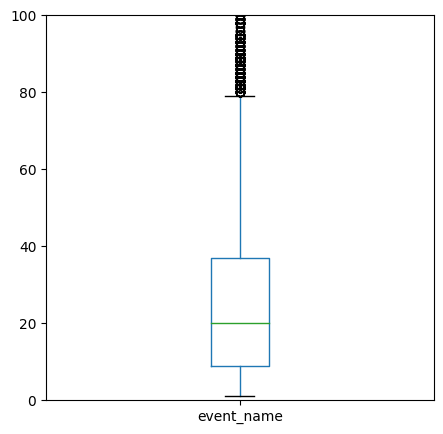

In [15]:
logs.groupby('user_id')['event_name'].count().plot.box(figsize=(5, 5))
plt.ylim(0, 100)
plt.show()

In [16]:
logs.groupby('user_id')['event_name'].count().describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

<font color=blue>**Среднее арифметическое количество событий на пользователя - 32, а медиана - 19. При этом по диаграмме размаха все значения, больше 80 считаются аномальными.**</font>

### Период исследования

In [17]:
# максимальная и минимальная даты
print('Минимальная дата логов: {}\nМаксимальная дата логов: {}'.format(logs['event_date'].min(),
                                                                       logs['event_date'].max()))

Минимальная дата логов: 2019-07-25 00:00:00
Максимальная дата логов: 2019-08-07 00:00:00


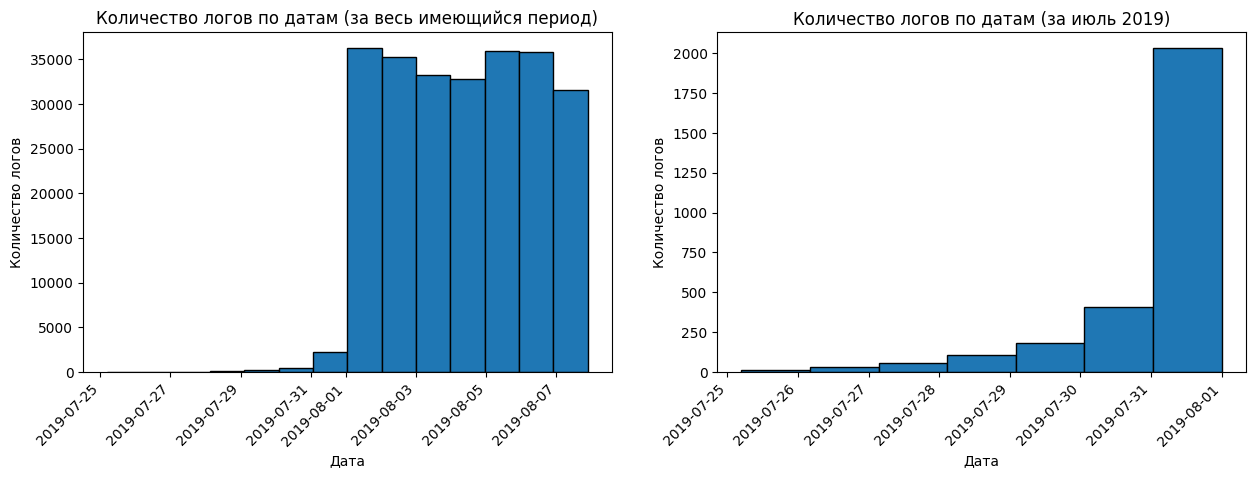

In [18]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(logs['event_date_time'], bins=14, ec='black') 
axes[0].set_title('Количество логов по датам (за весь имеющийся период)')
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Количество логов')

axes[1].hist(logs[logs['event_date_time'] < '2019-08-01']['event_date_time'], bins=7, ec='black') 
axes[1].set_title('Количество логов по датам (за июль 2019)')
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество логов')

fig.autofmt_xdate(rotation=45)
fig.set_figwidth(15)
fig.set_figheight(5)

plt.show()

**Судя по гистограмме: либо мы в конце июля 2019 только запустили приложение, и через недельку дела пошли очень хорошо (с 2 тысяч событий в день до 30-35 тысяч), либо, что более вероятно, мы располагаем не всеми данными за период наблюдений. Учитывая резкий скачок значений с 31 июля на 1 августа и отсутствие сильных колебаний в дальнейшем, можно сделать вывод, что наиболее полные данные у нас только за первую неделю августа 2019 года.**

### Изучение масштабов потерь при удалении неполных данных по дням

In [19]:
# проверка по событиям
date_threshold = pd.to_datetime('2019-08-01', format='%Y-%m-%d') # пороговая дата
print('Количество событий до 1 августа 2019 года: {}'.format(len(logs[logs['event_date'] < date_threshold])))
print('Всего событий в датафрейме: {}'.format(len(logs)))

print('Процент потерь событий при удалении данных за период до 1 августа 2019 года: {:.2%}'.format(len(logs[logs['event_date'] < date_threshold])
                                                                                           / len(logs)))

Количество событий до 1 августа 2019 года: 2826
Всего событий в датафрейме: 243713
Процент потерь событий при удалении данных за период до 1 августа 2019 года: 1.16%


In [20]:
# проверка по пользователям 
users_before_2019_08_01 = list(logs[logs['event_date'] < date_threshold]['user_id'].unique()) # уникальные пользователи до 1 августа 2019
users_after_2019_08_01 = list(logs[logs['event_date'] >= date_threshold]['user_id'].unique()) # уникальные пользователи после 1 августа 2019
lost_users = list(set(users_before_2019_08_01) - set(users_after_2019_08_01)) # уникальные "потерянные" пользователи 
print('Количество "потерянных" пользователей при удалении данных за период до 1 августа 2019 года: {}'.format(len(lost_users)))
print('Всего унакальных пользователей: {}'.format(logs['user_id'].nunique()))
print('Процент потерь пользователей при удалении данных за период до 1 августа 2019 года: {:.2%}'.format(len(lost_users) 
                                                                                                     / logs['user_id'].nunique()))

Количество "потерянных" пользователей при удалении данных за период до 1 августа 2019 года: 17
Всего унакальных пользователей: 7551
Процент потерь пользователей при удалении данных за период до 1 августа 2019 года: 0.23%


**Если мы для дальнейшего анализа оставим только данные с первого августа 2019 года, то потери будут незначительны: около 3 тысяч событий (при общем их числе 243 тысячи), что составляет 1% от общего их числа, и 17 пользователей (в то время как всего их было 7,5 тысяч), или около 0,2%.**

In [21]:
logs = logs[logs['event_date'] >= date_threshold]
logs['event_date'].describe()[4:6]

first    2019-08-01 00:00:00
last     2019-08-07 00:00:00
Name: event_date, dtype: object

<a id='count_users'></a>

 ### Количество пользователей в каждой группе

In [22]:
group_users = logs.groupby('exp_id').agg({'user_id': 'nunique'}).reset_index().rename(columns={'exp_id': 'group', 
                                                                                               'user_id': 'count_users'})
group_users

,group,count_users
0,246,2484
1,247,2513
2,248,2537


**Проверим, не случилось ли так, что пользователь попал в несколько групп сразу**

In [23]:
print('Количество уникальных пользователей после удалений: ' + str(logs['user_id'].nunique()))
print('Сумма пользователей по группам: ' + str(group_users['count_users'].sum()))

Количество уникальных пользователей после удалений: 7534
Сумма пользователей по группам: 7534


In [24]:
# второй способ проверки
logs.groupby('user_id')['exp_id'].nunique().sort_values(ascending=False).head(10)

user_id
6888746892508752       1
6204944347213293942    1
6215559225876063378    1
6215162890135937308    1
6213626876710715478    1
6213410662941116891    1
6212635085994550838    1
6212165738952028637    1
6212099346929060015    1
6210257982556180997    1
Name: exp_id, dtype: int64

**В каждой группе примерно равное количество пользователей. 
Также в датафрейме отсутствуют пользователи, попавшие в несколько групп.**

<font color=blue>**В датафрейме хранятся логи о 243 713 событиях, совершенных в период с 25 июля по 7 августа 2019 года. Каждое событие относится к одному из 5 видов: показ главного экрана, экран товара, корзина, экран оплаты и обучение. Логи собраны о 7 551 пользователе. В среднем на каждого пользователя приходится порядка 32 событий, однако, в данных присутствует довольно много выбросов, поэтому медианное значение равное 19, будет лучше отражать действительность. Учитывая, что данные распределены во времени неравномерно, так, например, в июле максимальное количество событий в день не превышало 2 тысяч, в то время, как за август этот показатель не опускался ниже отметки в 30 тысяч, было принято решение не учитывать в дальнейшем анализе июльские логи. Каждый из пользователей попал в одну из групп: контрольные (`246` и `247`) или экспериментальная (`248`). В каждой группе от 2 484 до 2 537 пользователей.**</font>

## Изучение воронки событий

### Виды событий в логах

In [25]:
# виды событий: 
print(list(logs['event_name'].unique()))

['Tutorial', 'MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']


**В датафрейме логи 5 видов событий:**
1. **`MainScreenAppear`** - появление главного экрана;
2. **`Tutorial`** - обучение использованию приложения;
3. **`OffersScreenAppear`** - окно с товаром;
4. **`CartScreenAppear`** - добавление(или открытие) в корзину;
5. **`PaymentScreenSuccessful`** - экран успешной оплаты заказа.

In [26]:
# количество событий каждого вида: 
logs_types = (logs['event_name']
              .value_counts()
              .sort_values(ascending=False)
              .to_frame()
              .rename(columns={'event_name': 'count_events'}))
logs_types 

,count_events
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


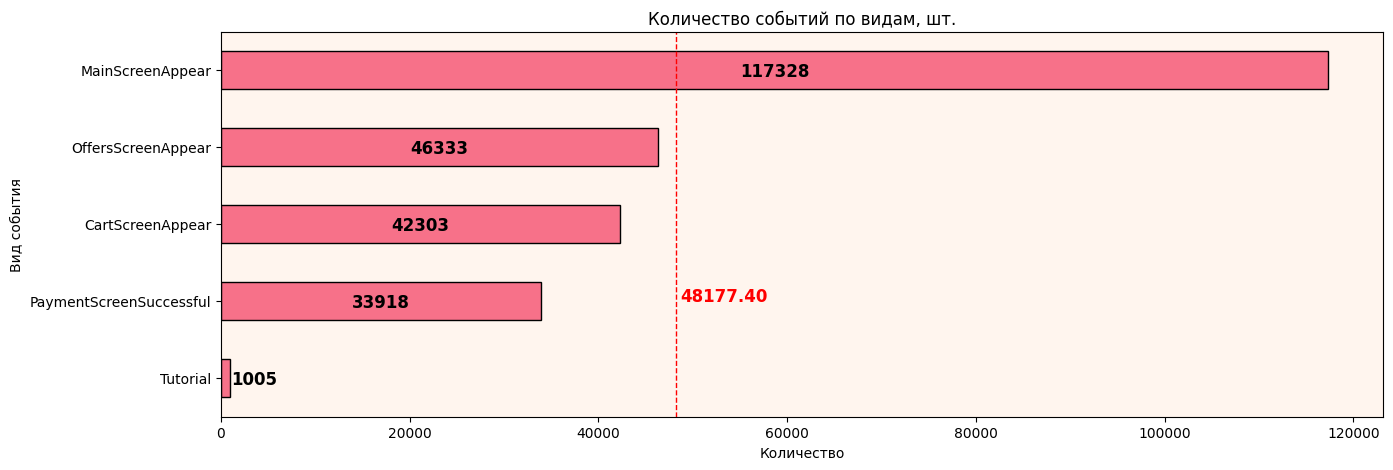

In [27]:
get_barh('count_events')

**Наиболее частое событие - показ главного экрана приложения, самое редкое - обучение.** 

### Анализ видов событий

#### Количество пользователей, совершавших каждое из событий

In [28]:
logs_types['count_users'] = logs.groupby('event_name')['user_id'].nunique()
logs_types

,count_events,count_users
MainScreenAppear,117328,7419
OffersScreenAppear,46333,4593
CartScreenAppear,42303,3734
PaymentScreenSuccessful,33918,3539
Tutorial,1005,840


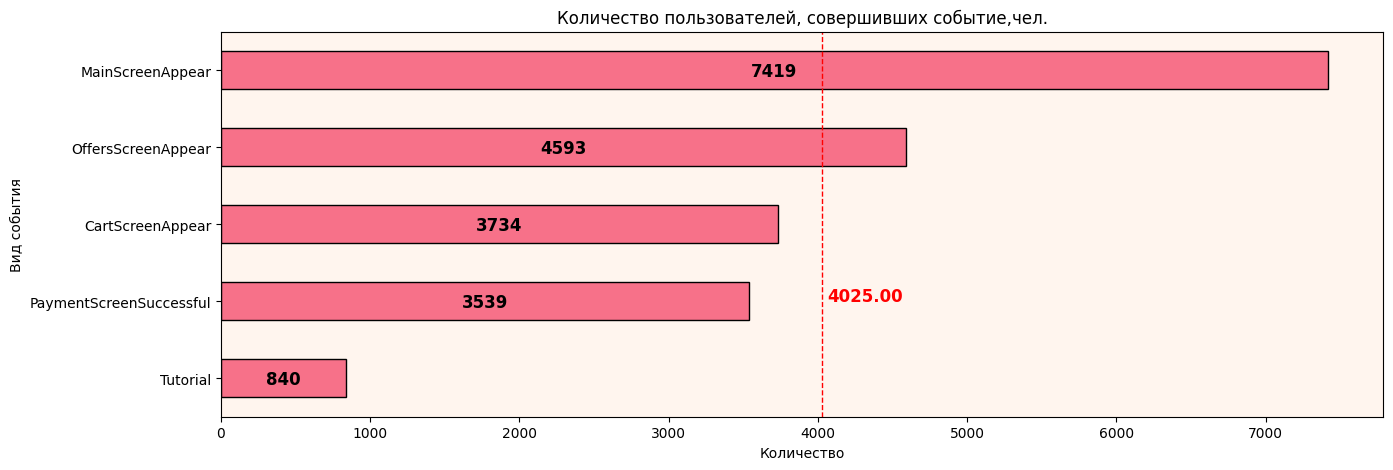

In [29]:
get_barh('count_users')

#### Доля пользователей, которые хоть раз совершали событие

In [30]:
logs_types['share_of_all_unique_users'] = round(logs_types['count_users'] / logs['user_id'].nunique(), 4)
logs_types.sort_values('share_of_all_unique_users', ascending=False)

,count_events,count_users,share_of_all_unique_users
MainScreenAppear,117328,7419,0.9847
OffersScreenAppear,46333,4593,0.6096
CartScreenAppear,42303,3734,0.4956
PaymentScreenSuccessful,33918,3539,0.4697
Tutorial,1005,840,0.1115


**Удивительно, что ни в однов из видов событий мы не получили единицу, в частности на этапе с `главным экраном`. Возможно, это связано с тем, что часть логов мы отсеяли ранее. Или же приложение устроено так, что можно его (главный экран) миновать, перейдя по прямой ссылке сразу в корзину или к карточке товара.**

### Порядок событий

События происходят в следующем порядке:

1. MainScreenAppear - главный экран;
2. Tutorial - обучение;
3. OffersScreenAppear - предложение о товаре (экран с товаром);
4. CartScreenAppear - добавление/переход в корзину;
5. PaymentScreenSuccessful - экран успешной оплаты заказа.

Прохождение обучения сильно выбивается из этой цепочки. Судя по всему, его можно отложить или пропустить, поскольку довольно маленький процент пользователей его прошел, при этом это нисколько не помешало им двигаться дальше.  
В дальнейших расчетах этот пункт учитывать не будем.

In [31]:
logs_types_without_tutorial = logs_types.drop(['Tutorial'])
logs_types_without_tutorial

,count_events,count_users,share_of_all_unique_users
MainScreenAppear,117328,7419,0.9847
OffersScreenAppear,46333,4593,0.6096
CartScreenAppear,42303,3734,0.4956
PaymentScreenSuccessful,33918,3539,0.4697


### Воронка событий

In [32]:
# конверсия 
logs_types_without_tutorial['conversion'] = 1
for i in range(1, len(logs_types_without_tutorial)):
    logs_types_without_tutorial['conversion'].iloc[i] = round(logs_types_without_tutorial['count_users'].iloc[i] /
                                                              logs_types_without_tutorial['count_users'].iloc[i-1], 2)
logs_types_without_tutorial

,count_events,count_users,share_of_all_unique_users,conversion
MainScreenAppear,117328,7419,0.9847,1.00
OffersScreenAppear,46333,4593,0.6096,0.62
CartScreenAppear,42303,3734,0.4956,0.81
PaymentScreenSuccessful,33918,3539,0.4697,0.95


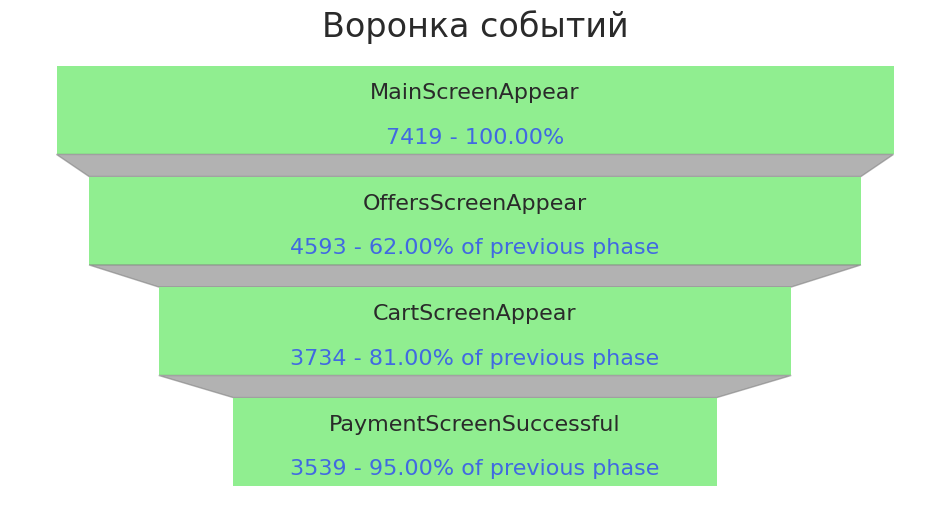

In [33]:
y = [4,3,2,1]
x = [90,83,68,52]
x_labels = list(logs_types_without_tutorial['count_users'])
x_conversion = list(logs_types_without_tutorial['conversion'])
labels = list(logs_types_without_tutorial.index)
x_max = 100
x_min = 0
x_range = x_max - x_min
fig, ax = plt.subplots(1, figsize=(12,6))
for idx, val in enumerate(x):
    left = (x_range - val)/2
    plt.barh(y[idx], x[idx], left = left, 
             color='#90EE90', height=.8)
    # label
    plt.text(50, y[idx]+0.1, labels[idx], ha='center',
              fontsize=16, color='#2A2A2A')
    # value
    if idx == 0:
        plt.text(50, y[idx]-0.3, '{} - {:.2%}'.format(x_labels[idx], x_conversion[idx]), ha='center',
              fontsize=16, color='#4169E1')
    else:
        plt.text(50, y[idx]-0.3, '{} - {:.2%} of previous phase'.format(x_labels[idx], x_conversion[idx]), ha='center',
              fontsize=16, color='#4169E1')
    
    if idx != len(x)-1:
        next_left = (x_range - x[idx+1])/2
        shadow_x = [left, next_left, 
                    100-next_left, 100-left, left]
        
        shadow_y = [y[idx]-0.4, y[idx+1]+0.4, 
                    y[idx+1]+0.4, y[idx]-0.4, y[idx]-0.4]
        plt.fill(shadow_x, shadow_y, color='grey', alpha=0.6)
plt.xlim(x_min, x_max)
plt.axis('off')
plt.title('Воронка событий', loc='center', fontsize=24, color='#2A2A2A')
plt.show()

**Разультаты вполне реальные: лишь треть всех пользователей переходит на экран товара, 80% из них добавляют что-то в корзину, а если уж в корзине что-то есть, то только 5% не доходят до заветного "оплата проведена успешно".** 

### "Наибольшие потери в конверсии"

In [34]:
conv_losses = (logs_types_without_tutorial.reset_index()
                                          .rename(columns={'index': 'event_type'})
                                          .copy()
           )
conv_losses['conversion_losses'] = 1
for i in range(1, len(conv_losses)):
    conv_losses['conversion_losses'].iloc[i] = round(conv_losses['conversion'].iloc[i] - 1, 2)
conv_losses = conv_losses[['event_type', 'conversion', 'conversion_losses']]
conv_losses

,event_type,conversion,conversion_losses
0,MainScreenAppear,1.00,1.00
1,OffersScreenAppear,0.62,-0.38
2,CartScreenAppear,0.81,-0.19
3,PaymentScreenSuccessful,0.95,-0.05


**Больше всего пользователи "отваливаются" при переходе от главного экрана к экрану с товаром - 38%. Закономерное явление: большинство  заходит без конкретной цели, просто посмотреть. Однако, если пользователель перешел на экран с товаром, то скорее всего он дойдет до покупки: после просмотра экрана с товаром "отваливаются" только 19% пользователей, а уж если добавили товар в корзину, то купят его 95% пользователей. Такие относительно хорошие цифры на последних этапах перед покупкой могут быть связаны со спецификой приложения - продукты питания: стоимость на такая большая, как, например, у вещей, а потребность высокая. Нет смысла добавлять в корзину и ждать скидок, распродаж или просто зарплаты =)**

### Доля пользователей, которые доходят от первого события до оплаты

In [35]:
print('Доля пользователей, которые доходят от первого события до оплаты: {}'.format(round(logs_types_without_tutorial.loc['PaymentScreenSuccessful', 'count_users'] / logs['user_id'].nunique(), 4)))

Доля пользователей, которые доходят от первого события до оплаты: 0.4697


## Изучение результатов эксперимента

### Количество пользователей в каждой (одной) экспериментальной группе

<div style="border:solid blue 3px; padding: 20px">
<div class="alert alert-info">
    Такое уже просили вот тут 👇
</div>
</div>

[<font color='red'>Количество пользователей в группе</font>](#count_users)

In [36]:
group_users

,group,count_users
0,246,2484
1,247,2513
2,248,2537


### Проверка гипотезы о равенстве долей

Для проверки гипотезы о равенстве долей двух контрольных групп (`246` и `247`) воспользуемся Z-тестом: разница между пропорциями, наблюдаемыми на выборках, будет нашей статистикой. Можно доказать, что она распределена нормально:

![Z](https://pictures.s3.yandex.net/resources/Screenshot_2019-09-30_at_21.06.40_1569866809.png)

где, 
`величина Z` — стандартная для критерия со стандартным нормальным распределением: со средним, равным нулю, и стандартным отклонением, равным единице. Это указано в правой части формулы после ～ знака, который говорит, что выражение распределено как N(0,1); 

`n₁` и `n₂` — размеры двух сравниваемых выборок, то есть количество наблюдений в них; 

`P₁`, `P₂` — пропорции, наблюдаемые в выборках; 

`P` — пропорция в выборке, скомбинированной из двух наблюдаемых; 

`π₁`, `π₂` — настоящие пропорции в сравниваемой генеральной совокупности (`π₁ - π₂ = 0`).

Для применения формулы нам не хватает некоторых данных, а именно: 
1. `P₁`, `P₂`
2. `P`

Одним из критериев успешного A/A-теста является то, что количество пользователей в различных группах различается не более, чем на 1%. Проверим:

In [37]:
print('Различие в количестве пользователей групп 246 и 247: {:.2%}'.format(round(group_users.loc[1, 'count_users'] /
                                                                       group_users.loc[0, 'count_users'] - 1, 4)))

Различие в количестве пользователей групп 246 и 247: 1.17%


**Чуть больше процента, но работаем с тем, что есть.**

Гипотеза $H_{0}$ (нулевая): между долями нет значимой разницы.  
Гипотеза $H_{1}$ (альтернативная): между долями значимая разница есть.   
Уровень статистической значимости `alpha`: 0.05

In [38]:
group_users = group_users.merge(logs.pivot_table(index='exp_id', 
                                                 columns='event_name', 
                                                 values='user_id', 
                                                 aggfunc='nunique'), 
                                left_on='group', 
                                right_on='exp_id', 
                                how='left')
group_users

,group,count_users,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,2484,1266,2450,1542,1200,278
1,247,2513,1238,2476,1520,1158,283
2,248,2537,1230,2493,1531,1181,279


In [39]:
hypotheses_test_result(246, 247)

alpha: 0.05
По доле MainScreenAppear
p-значение:  0.7571
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле OffersScreenAppear
p-значение:  0.2481
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле CartScreenAppear
p-значение:  0.2288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле PaymentScreenSuccessful
p-значение:  0.1146
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле Tutorial
p-значение:  0.9377
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 



<font color=blue>Главная цель А/А-теста — показать, можно ли доверять результатам эксперимента, который будет запущен в тех же условиях, но уже для контрольной и эксперименталой группы - с измененным шрифтом. Он позволяет убедиться, что на результат не влияют аномалии и выбросы в генеральной совокупности, что инструмент "деления" трафика работает безошибочно и что данные отправляются в системы аналитики корректно. В общем и целом, А/А-тестирование - способ проверить корректность работы механизма A/B-тестирования: если в ходе А/А-теста победителя выявить не удалось, можно запускать А/В-тест. В противном случае придется проверить настройки сервиса и однородность выборки. Поскольку ни один из A/A-тестов не выявил значимых различий в показателях двух контрольных групп, можно сделать вывод, что выборка у нас однородна и система, в которой мы проводим эксперимент, работает правильно, следовательно, при дальнейшем проведении А/В-тестов их результатам можно будет доверять.</font>

Поскольку мы проводим несколько сравнений на одних и тех же данных, с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Это групповая вероятность ошибки первого рода, или FWER.
![Ошибки](https://pictures.s3.yandex.net/resources/vernaya_gipoteza-75f710d1-b38b-4f78-b135-da6f7eea0b0f_1569200659.jpg)
Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня значимости для уменьшения FWER.  
В функцию заложена самая распространенная и, в то же время, самая грубая поправка к требуемым уровням значимости - поправка Бонферрони: уровни значимости в каждом из m сравнений в m раз меньше, чем уровень значимости, требуемый при единственном сравнении. Проще говоря, необходимо разделить уровень значимости ɑ на число гипотез. Однако, в нашем случае нет смысла ее использовать, поскольку ни один тест итак не дал возможность отвергнуть нулевую гипотезу (поправка уменьшает p-value). 

**Значимых отличий между двумя А-группами не обнаружено.**

### Самое популярное событие

In [40]:
group_users.apply({'MainScreenAppear': 'sum', 
                                    'OffersScreenAppear': 'sum', 
                                    'CartScreenAppear': 'sum',
                                    'PaymentScreenSuccessful': 'sum', 
                                    'Tutorial': 'sum'}).sort_values(ascending=False)

MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
dtype: int64

**Как ни странно, но самое популярное событие - это главный экран, меньше тысячи человек прошли обучение (сначала ломаем, потом смотрим инструкцию, все правильно =))**

In [41]:
# число пользователей, совершивших самое популярное событие по группам (и доля)
popular_event = group_users.loc[:, ['group', 'MainScreenAppear']]
popular_event['share'] = round(popular_event['MainScreenAppear'] / logs['user_id'].nunique(), 4)
popular_event

,group,MainScreenAppear,share
0,246,2450,0.3252
1,247,2476,0.3286
2,248,2493,0.3309


### А/В-тесты

In [42]:
# проверка групп 246 и 248
hypotheses_test_result(246, 248)

alpha: 0.05
По доле MainScreenAppear
p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле OffersScreenAppear
p-значение:  0.2084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле CartScreenAppear
p-значение:  0.0784
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле PaymentScreenSuccessful
p-значение:  0.2123
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле Tutorial
p-значение:  0.8264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 



In [43]:
# проверка групп 247 и 248
hypotheses_test_result(247, 248)

alpha: 0.05
По доле MainScreenAppear
p-значение:  0.4587
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле OffersScreenAppear
p-значение:  0.9198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле CartScreenAppear
p-значение:  0.5786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле PaymentScreenSuccessful
p-значение:  0.7373
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле Tutorial
p-значение:  0.7653
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 



Для проверки экспериментальной группы с объединенной контрольной группой сначала добавим все необходимые данные в таблицу.

In [44]:
group_users

,group,count_users,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,2484,1266,2450,1542,1200,278
1,247,2513,1238,2476,1520,1158,283
2,248,2537,1230,2493,1531,1181,279


In [45]:
new_row = group_users.loc[0] + group_users.loc[1]
new_row.name = '246+247'
group_users.loc['246+247'] = new_row
group_users.reset_index(drop=True)
group_users.loc['246+247', 'group'] = 249
group_users

,group,count_users,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
0,246,2484,1266,2450,1542,1200,278
1,247,2513,1238,2476,1520,1158,283
2,248,2537,1230,2493,1531,1181,279
246+247,249,4997,2504,4926,3062,2358,561


In [46]:
# проверка объединенной контрольной группы и 248
hypotheses_test_result(249, 248)

alpha: 0.05
По доле MainScreenAppear
p-значение:  0.2942
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле OffersScreenAppear
p-значение:  0.4343
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле CartScreenAppear
p-значение:  0.1818
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле PaymentScreenSuccessful
p-значение:  0.6004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 

По доле Tutorial
p-значение:  0.7649
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 



**Изменение шрифта в приложении никак не сказалось на поведении пользователей: ни одна из метрик существенно не изменилась, следовательно, введение нового шрифта с точки зрения изменения UX никак не повлияет на бизнес.**

### Поправка при расчетах 

При проверке статистических гипотез мы установили статистическую значимость на уровне 0,05. 
Количество проведенных проверок - 20 (5 - $A_{1}$ / $A_{2}$; 5 - $A_{1}$ / B; 5 - $A_{2}$ / B; 5 - $A_{12}$ / B). В принципе, как я уже писал выше, надобности в поправке нет, поскольку лишь в одном тесте (`группы 246 и 248 CartScreenAppear`) p-value приблизилось к отметке 0,05. А поправка еще сильнее уменьшит `alpha-значение`. Посмотрим на одном примере, что параметр в функции работает исправно. Для этого, правда, придется использовать нереалистичные данные.

In [47]:
hypotheses_test_result(246, 248, bonferrony=0.1) # чтобы получить уровень статистической значимости 0,5

alpha: 0.5
По доле MainScreenAppear
p-значение:  0.295
Отвергаем нулевую гипотезу: между долями есть значимая разница 

По доле OffersScreenAppear
p-значение:  0.2084
Отвергаем нулевую гипотезу: между долями есть значимая разница 

По доле CartScreenAppear
p-значение:  0.0784
Отвергаем нулевую гипотезу: между долями есть значимая разница 

По доле PaymentScreenSuccessful
p-значение:  0.2123
Отвергаем нулевую гипотезу: между долями есть значимая разница 

По доле Tutorial
p-значение:  0.8264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными 



Как мы можем видеть, поправка работает: p-value равное 0,2084 позволяет нам отвергнуть нулевую гипотезу, а 0,8264 - нет. 

**Выводы: проведя А/А-тест, мы убедились, что статистически значимых различий между A-группами (`246 и 247`) нет, следовательно, "система тестирования" настроена правильно и дальнейшим A/B-тестам можно доверять. В ходе A/B тестов статистически значимых различий выявить тоже не удалось, это говорит о том, что изменение шрифта в приложении никак не скажется на поведении пользователей, а значит, его изменение не навредит бизнесу.
Несмотря на то, что период исследования включал в себя только одну неделю, учитывая полученные значения p-value, ожидать того, что ситуация кардинально изменится с увеличением срока наблюдения не приходится. Так как на пользователей изменение шрифта не повлияет, стоит рассмотреть этот вопрос и с других точек зрения: трудоемкость, стоимость.**